# Tutorial 2: add prior information into the training in low data regime 

If you didn't install dlim: !pip install dlim

dlim includes:
- DLIM: model 
- utils: for data and training 
- plot_figure: for plotting figures
- sim_data: simulate data points 


In [1]:
# Standard imports 
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from numpy import mean, logspace, std
from numpy.random import choice, seed
import matplotlib.pyplot as plt
from multiprocessing import Pool

# Load dlim model and data 
from dlim import DLIM
from dlim.utils import Data_model, train

### Load the data 

Data_model will load data and change them into tensor 
- infile: the file with N genes 
    - The first N columns will be the mutation on each gene
    - The last column will be the fitness value 
    - You should not include the head and index for your own csv file 
- const_file: add the file with prior information
    - In this file, there are three columns, the first column is to indicate the indices of the gene, i.e., 1, 2, ... (in Kemble et al dataset there are only two genes)
    - the second column and third column are the mutations on this gene whose functions are similar. 
- nb_var: the number of genes, N.

In [2]:
data = Data_model(infile = "./data/data_env_1.csv", nb_var = 2, const_file="./data/data_const.dat")
data_no = Data_model(infile = "./data/data_env_1.csv", nb_var = 2)

###  Keep 30% of data as validation, and examine the performance of D-LIM with different scales of training dataset size 

In [3]:
val_frac = logspace(-2, 0.1, num=7)
val_id = choice(range(data.data.shape[0]), int(data.data.shape[0]*0.3))
train_full_id = [i for i in range(data.data.shape[0]) if i not in val_id]
train_full_data = data[train_full_id, :]
val_data = data[val_id, :]

### Define the function to execute the model with and without prior information 

In [4]:
def run_one(args):
    i, frac = args
    seed(42 + i)
    train_id = choice(range(train_full_data.shape[0]), int(train_full_data.shape[0]*frac))
    # define the model 
    model = DLIM(2, nb_state=37, hid=32, nb_layer=1)
    model_no = DLIM(2, nb_state=37, hid=32, nb_layer=1)

    # get certain percentage of training dataset 
    train_data = train_full_data[train_id, :]


    # --- begin to train the model ---------------
    _ = train(model, train_data, const=data.const, lr=1e-2, wei_const=10, wei_dec=1e-3, nb_epoch=300, bsize=64)
    _ = train(model_no, train_data, lr=1e-2, wei_dec=1e-3, nb_epoch=300, bsize=64)

    fit = model(val_data[:, :-1].int())[0].detach().squeeze(-1)
    fit_no = model_no(val_data[:, :-1].int())[0].detach().squeeze(-1)
    cor_w = pearsonr(fit, val_data[:, -1])[0]
    cor_n = pearsonr(fit_no, val_data[:, -1])[0]
    return cor_w, cor_n

### Multiprocess to train models w

In [5]:
result = {
    'with reg': [],
    'no reg': []
}
pool = Pool(20)
for frac in val_frac:
    res = pool.map(run_one, [(i, frac) for i in range(10)])
    tmp_w, tmp_n = zip(*res)
    result['with reg'] += [tmp_w]
    result['no reg'] += [tmp_n]

### Visualization of models' performance with various sizes of training dataset

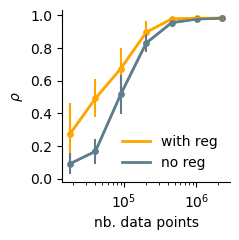

In [7]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
val_frac = val_frac * data.data.shape[0]
# you can define your own color 
colors = ['#ffa500', '#607d8b']
for id, model_name in enumerate(result.keys()):
    y = [mean(el) for el in result[model_name]] 
    yerr = [std(el) for el in result[model_name]] 
    ax.plot(val_frac, y, c=colors[id], lw=2, label=model_name)
    ax.scatter(val_frac, y, c=colors[id], s=15)
    ax.errorbar(val_frac, y, yerr=yerr, c=colors[id])
ax.set_xscale("log")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
ax.set_ylabel("$\\rho$")
ax.set_xlabel("nb. data points")
ax.legend(frameon=False)
plt.tight_layout()
plt.show()